In [1]:
# %matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from warnings import filterwarnings
import missingno as msno

filterwarnings('ignore')

# https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/

#About 10 day lags & live 50 days
#-------------------------------
# Larvae 1~2 days
# Pupae Within 7~10 days
# The average adult female mosquito can live up to 42-56 days
# Given this - it's likely a TimeSeries problem
# Also, Not sure why splitting the data to SJ or IQ makes real difference

# Have missing data so forward fill = ffill & 
# week_start_date is duplicated by week number

## Loading Data

In [2]:
# Loading CSV & dropping "week_start_date" as I have other time marker like 
df_train_y = pd.read_csv('./dengue_labels_train.csv', index_col=[0, 1, 2])
df_train_x = pd.read_csv('./dengue_features_train.csv', index_col=[0, 1, 2]).drop('week_start_date', axis=1)
df_test_x = pd.read_csv('./dengue_features_test.csv',  index_col=[0, 1, 2]).drop( 'week_start_date', axis=1)

# checking to making sure columns names & columnames train vs. test
print(df_train_x.columns)
print(df_test_x.columns == df_train_x.columns)

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


### Converting Kelvin measurement to Celsius as I lack intuition about Kelvin

In [3]:
def convert_kelvin_to_celsius(X):
    # List of columns in Kelvin 
    convert_to_celsius = [f_name for f_name in X.columns if re.match('^reanalysis.+k$',f_name)]
    # Converting Kelvin to Celsius
    X[convert_to_celsius] -= 273.15
     # Replacing column names with K to C suffix
    X.columns = [re.sub('^reanalysis.+k$',f_name[:-1]+'c',f_name) for f_name in X.columns]
    return X

df_train_x = convert_kelvin_to_celsius(df_train_x)
df_test_x = convert_kelvin_to_celsius(df_test_x)

print(df_train_x.columns)

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_c', 'reanalysis_avg_temp_c',
       'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')


## Missing value counts & visualization

Count of Nulls per features
ndvi_ne                    194
ndvi_nw                     52
station_diur_temp_rng_c     43
station_avg_temp_c          43
ndvi_sw                     22
dtype: int64


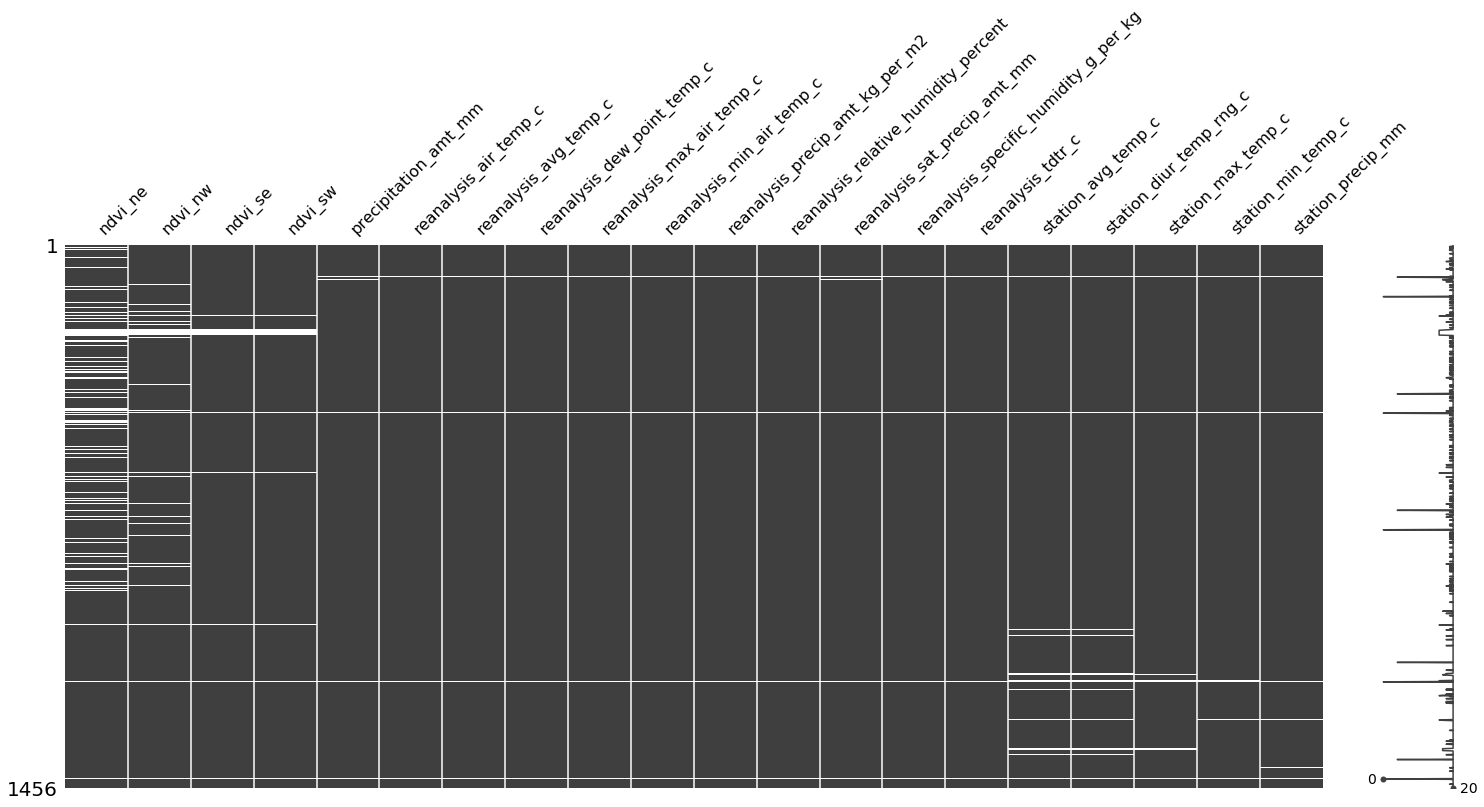

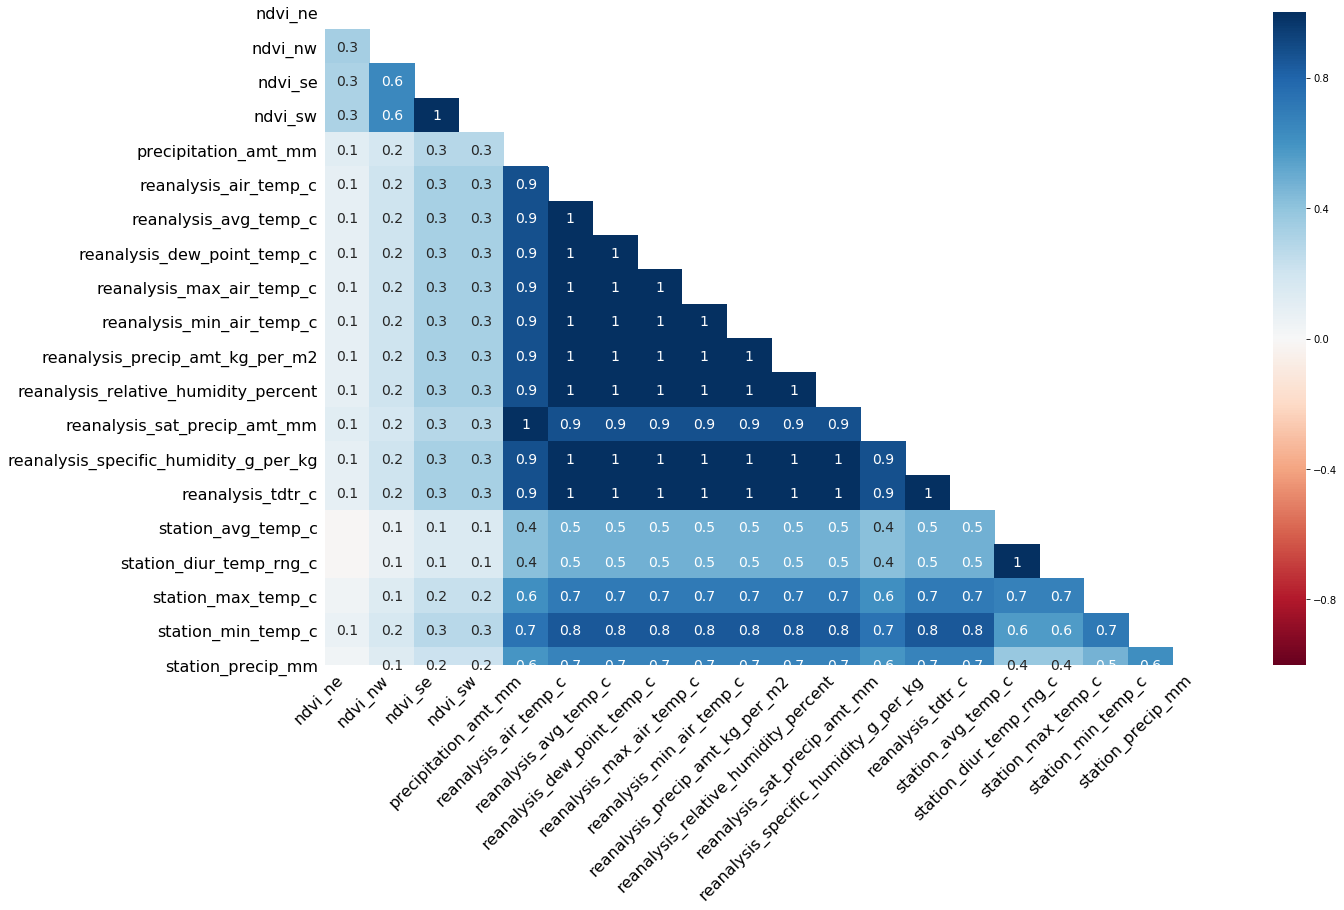

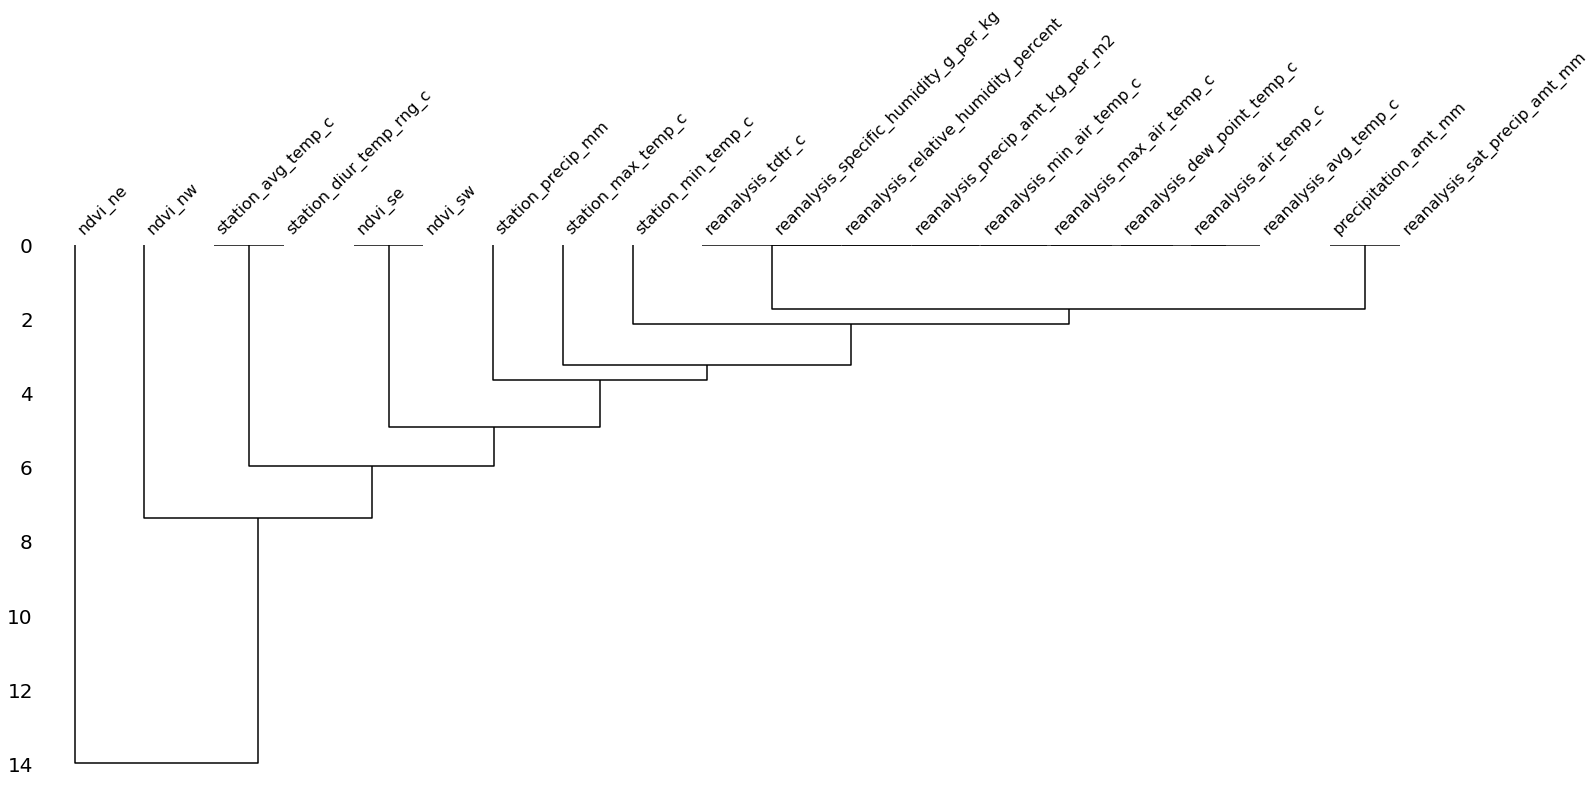

In [4]:
print('Count of Nulls per features')
print(df_train_x.isnull().sum(axis=0).sort_values(ascending=False).head())

msno.matrix(df_train_x)
msno.heatmap(df_train_x)
msno.dendrogram(df_train_x)
#msno.matrix(df_test_x)

In [5]:
# Filling prev value for Missing value
df_train_x.fillna(method='ffill', inplace=True)
df_test_x.fillna(method='ffill', inplace=True)
print(df_train_x.isnull().sum(axis=0).sort_values(ascending=False).head())

station_precip_mm     0
station_min_temp_c    0
ndvi_nw               0
ndvi_se               0
ndvi_sw               0
dtype: int64


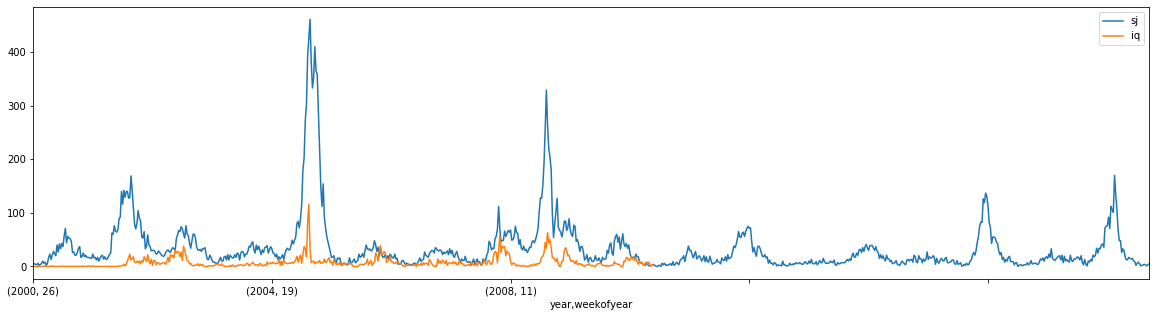

count SJ: 936   IQ: 520
Above shows iq has abouit 1/2 count of sj


In [6]:
# Quick Graph to show total_cases 
plt.figure(figsize = (20, 5))
(df_train_y.loc['sj']
     .total_cases
     .plot(label='sj'))
(df_train_y.loc['iq']
     .total_cases
     .plot(label='iq'))
plt.legend()
plt.show()
# Graph show pretty strong correlation 

print("count SJ: {}   IQ: {}".format(df_train_y.loc['sj'].shape[0], df_train_y.loc['iq'].shape[0]))
print("Above shows iq has abouit 1/2 count of sj")

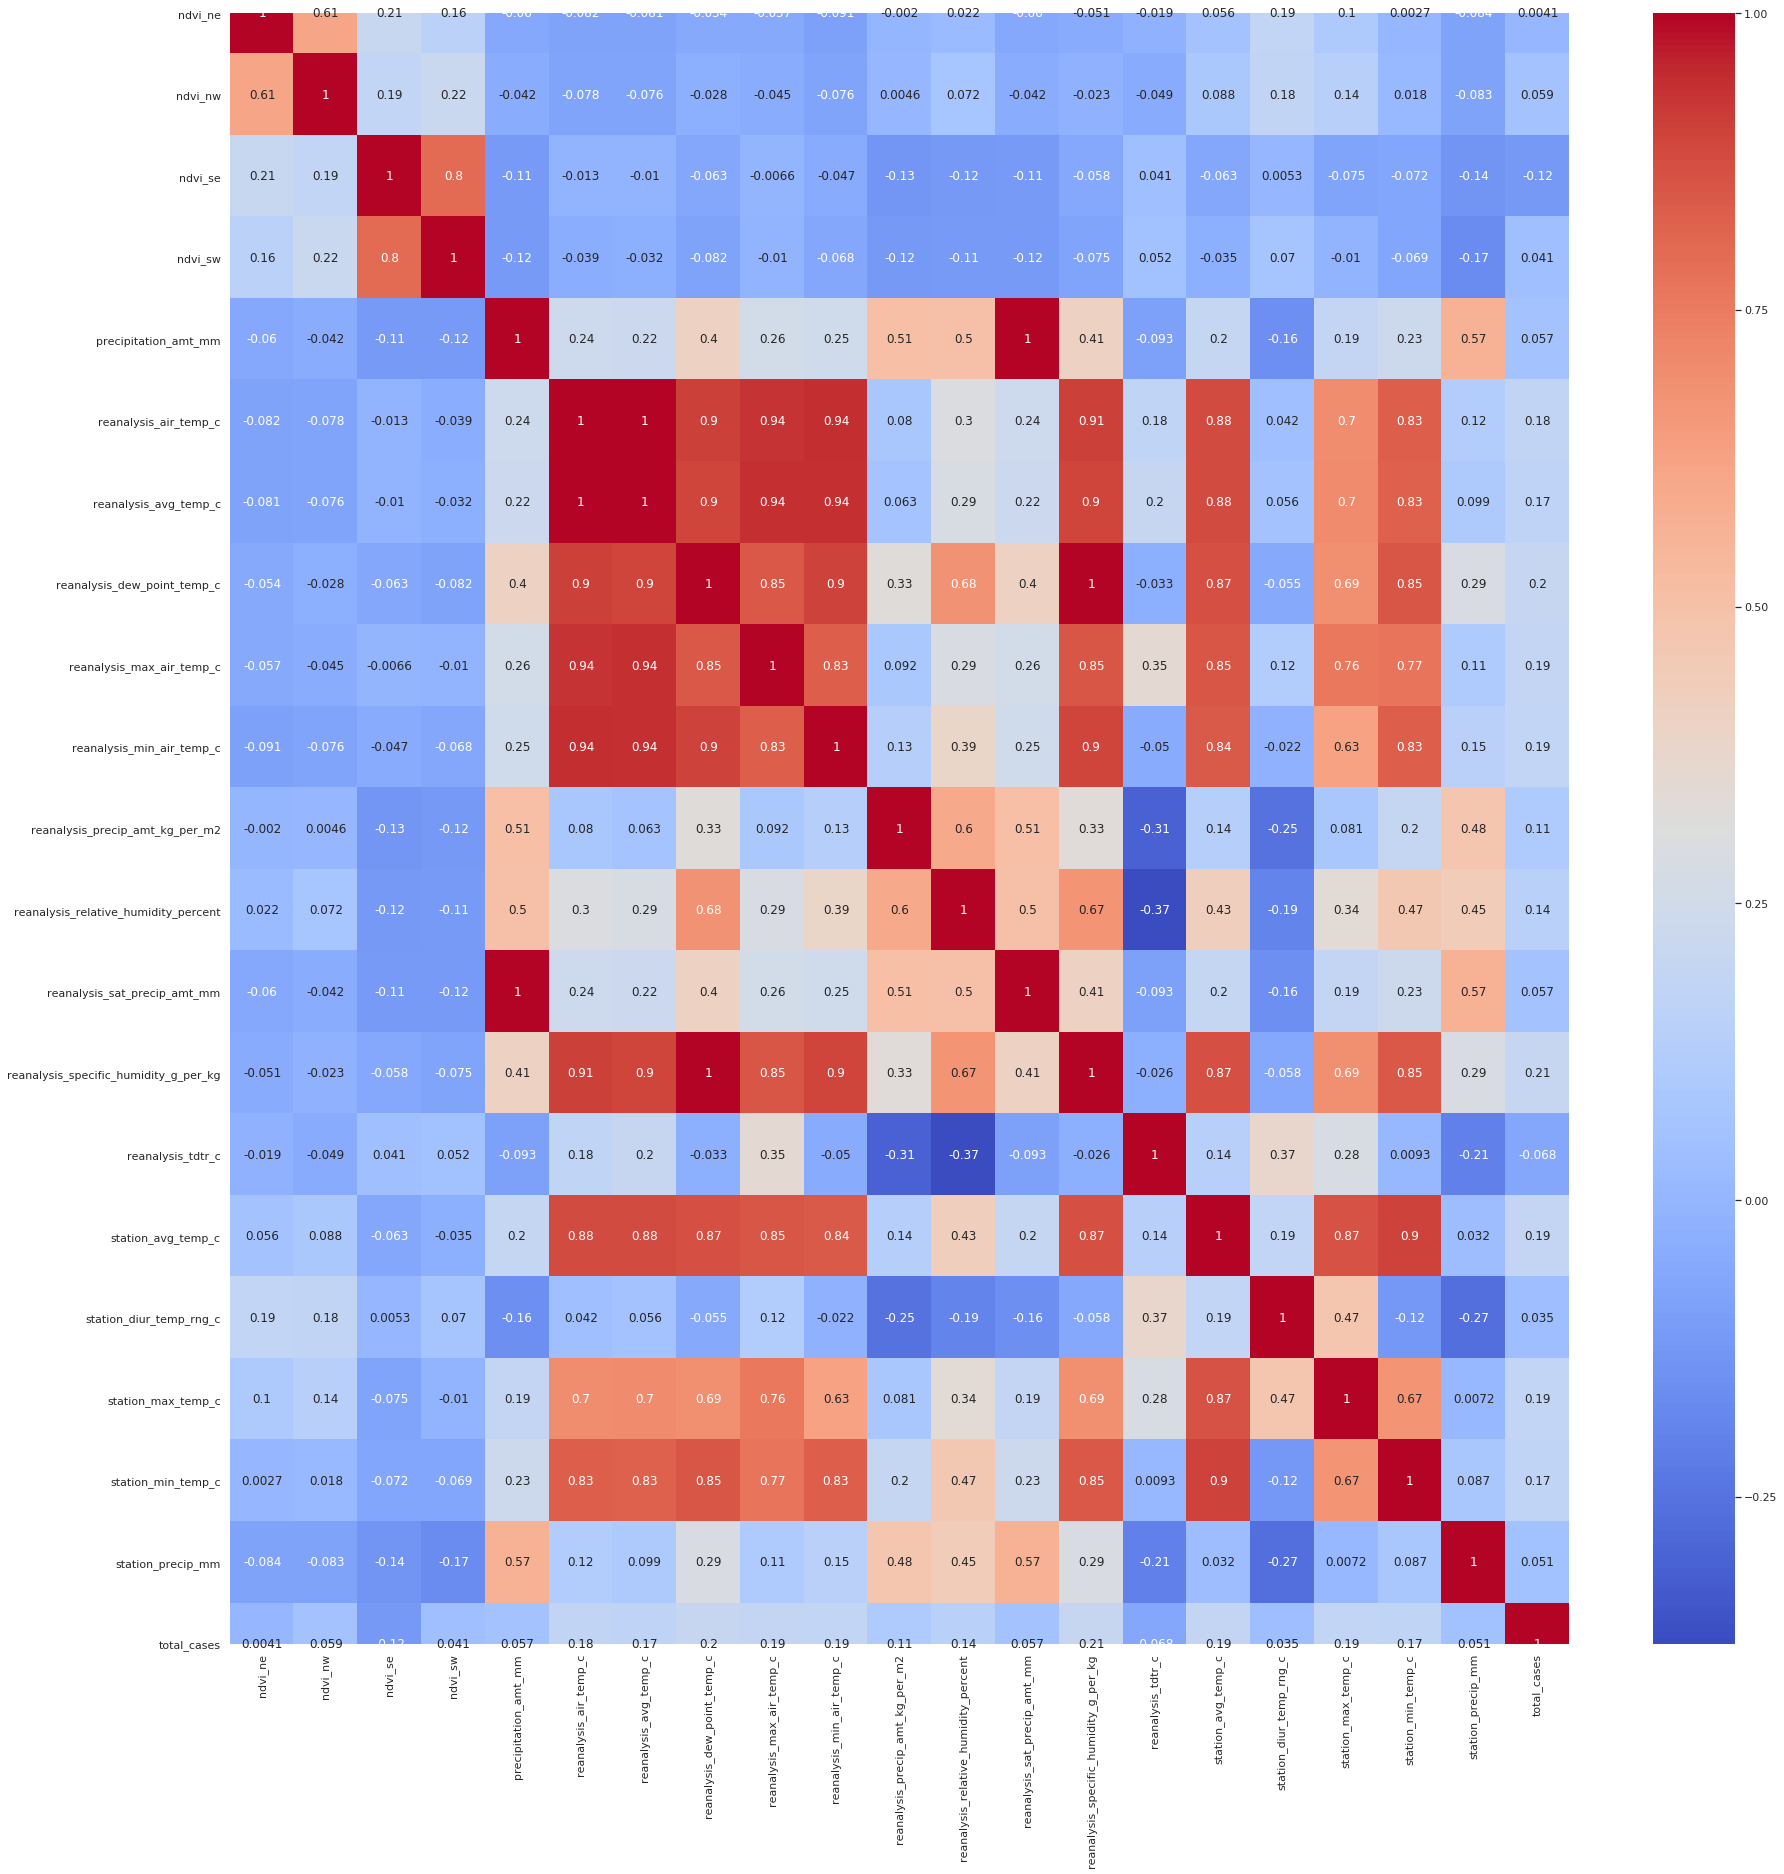

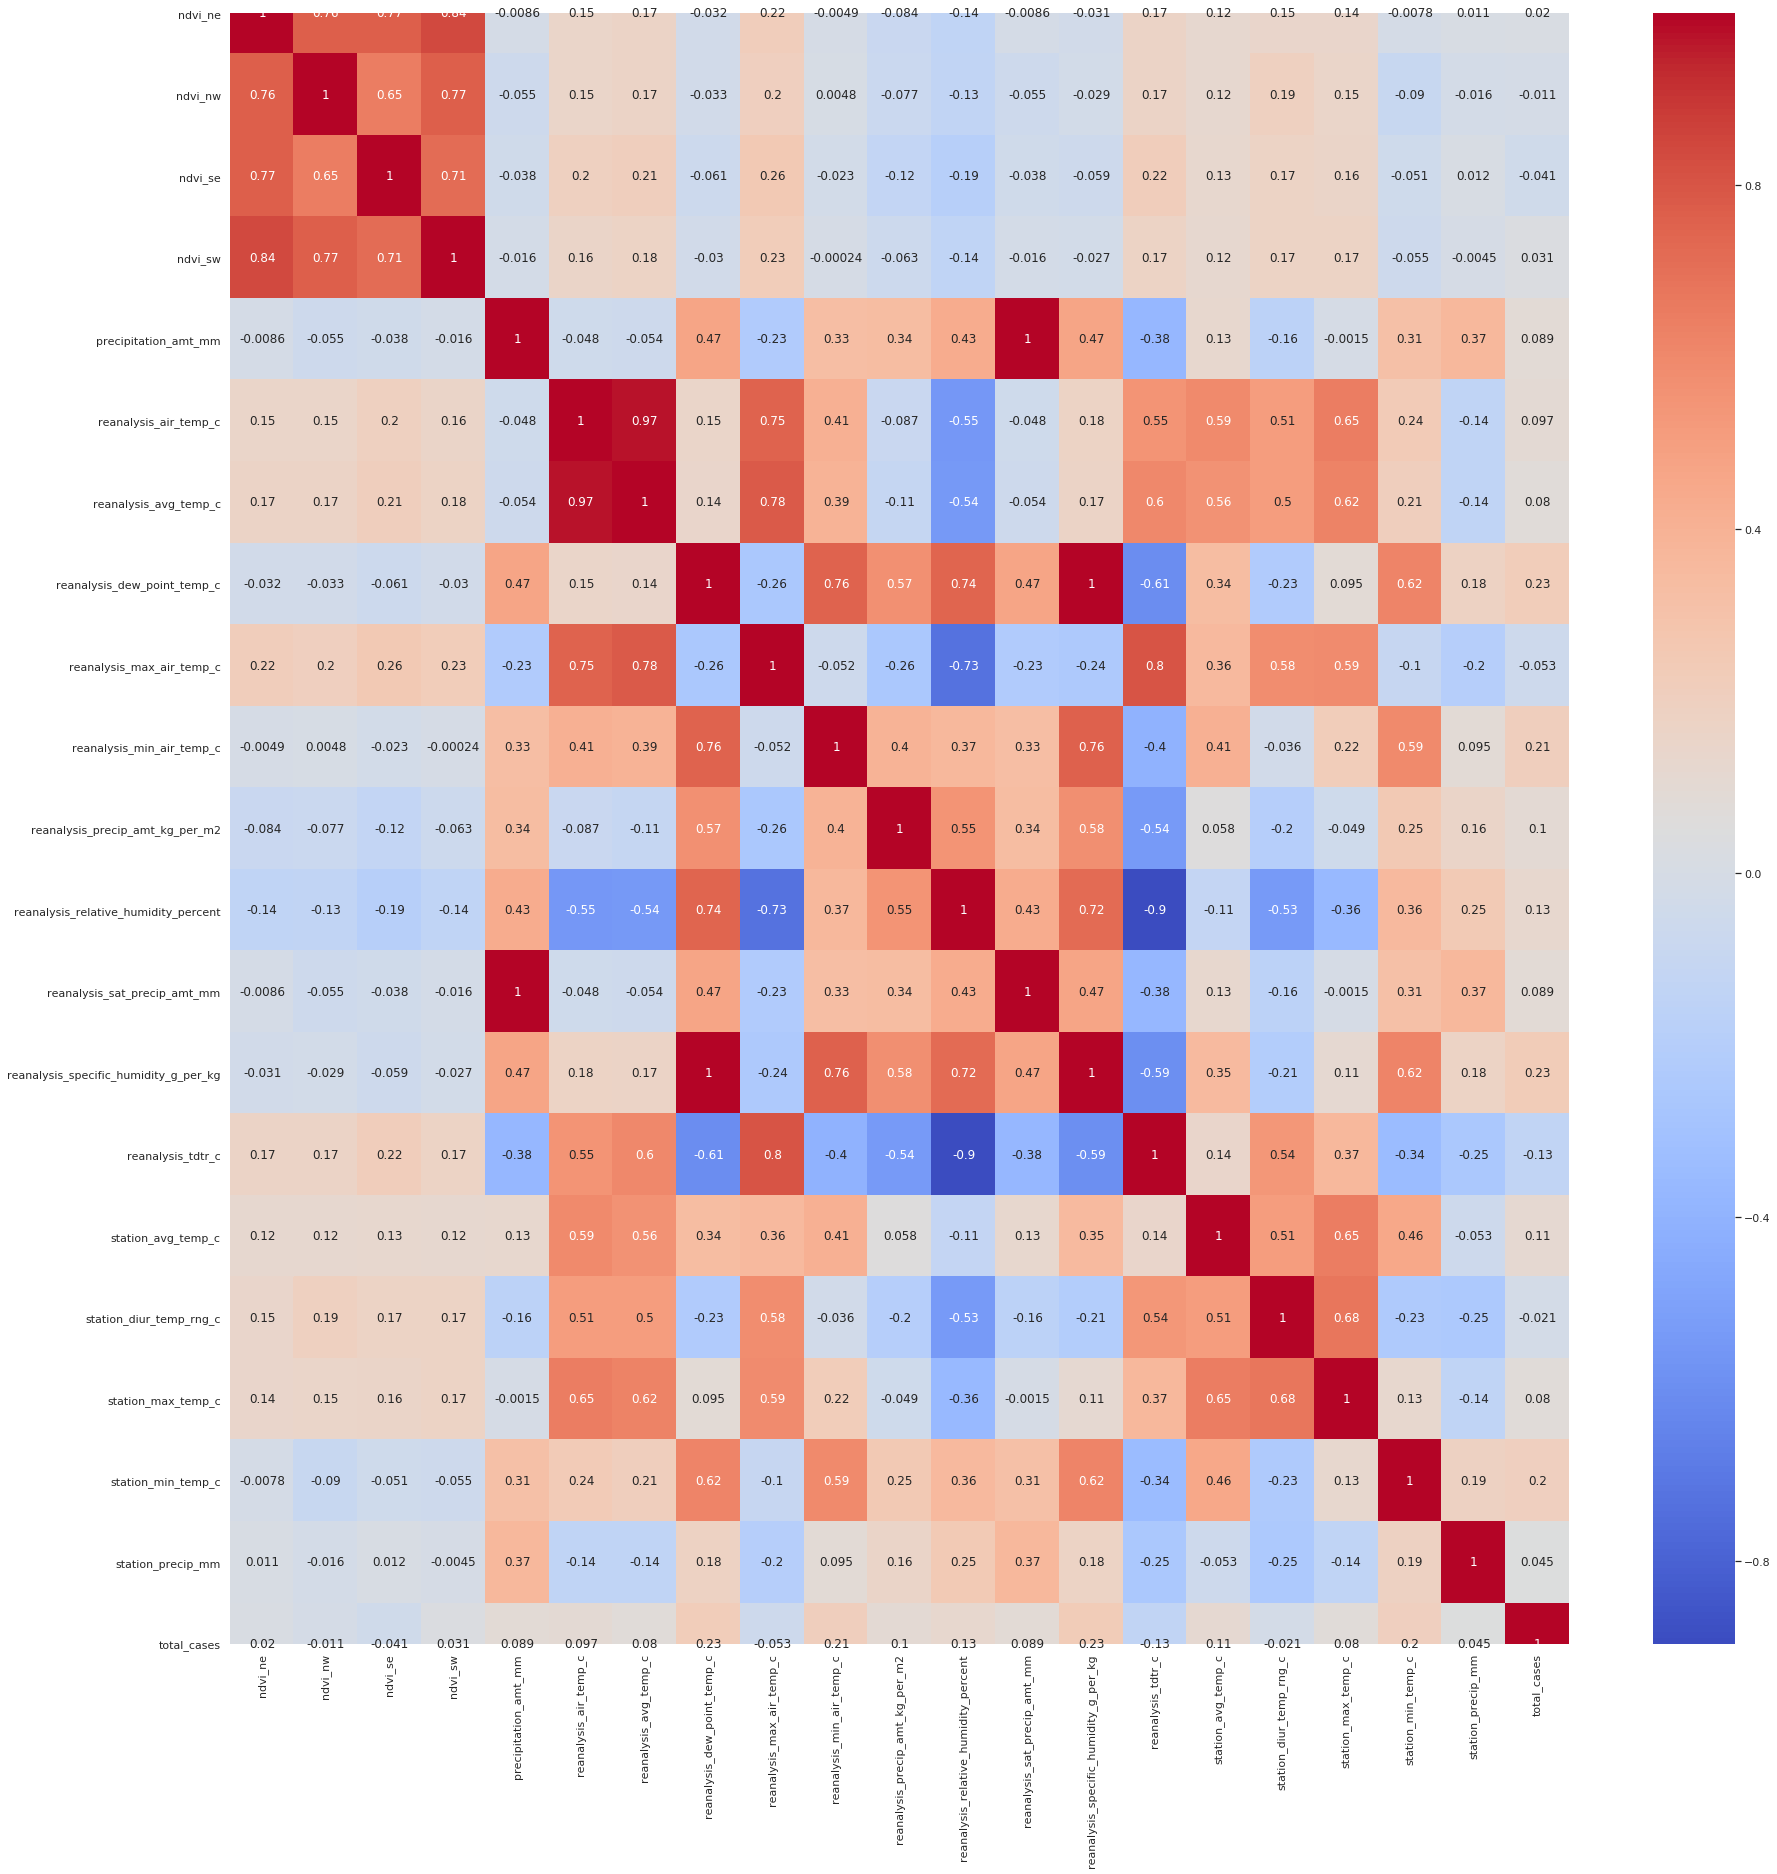

In [7]:
sj_tmp_x = df_train_x.loc['sj']
sj_tmp_x['total_cases'] = df_train_y.loc['sj']['total_cases'] 
sj_x_corr = sj_tmp_x.corr() 

sns.set(font_scale=1)
plt.figure(figsize=(30, 30))
sns.heatmap(sj_x_corr, cmap='coolwarm', annot=True)
plt.show()

iq_tmp_x = df_train_x.loc['iq']
iq_tmp_x['total_cases'] = df_train_y.loc['iq']['total_cases'] 
iq_x_corr = iq_tmp_x.corr() 

sns.set(font_scale=1)
plt.figure(figsize=(30, 30))
sns.heatmap(iq_x_corr, cmap='coolwarm', annot=True)
plt.show()

- Features do NOT show high correlation w/ total_cases looking at the light colors
- Especially ndvi vegitations

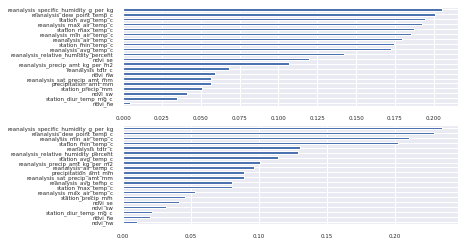

In [8]:
sns.set(font_scale=.5)
fig, axes = plt.subplots(2,1)
abs(sj_x_corr).total_cases.drop('total_cases').sort_values().plot(kind='barh', label='SJ', ax=axes[0])
abs(iq_x_corr).total_cases.drop('total_cases').sort_values().plot(kind='barh', label='SJ', ax=axes[1])
plt.show()

### taking only significant cols 

In [9]:
sj_sig_cols = abs(sj_x_corr).total_cases.drop('total_cases').where(lambda x: x > .15).dropna().index
iq_sig_cols = abs(iq_x_corr).total_cases.drop('total_cases').where(lambda x: x > .2).dropna().index

print('sj_cols=', sj_sig_cols.tolist())
print('iq_cols=', iq_sig_cols.tolist())

sj_cols= ['reanalysis_air_temp_c', 'reanalysis_avg_temp_c', 'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c', 'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']
iq_cols= ['reanalysis_dew_point_temp_c', 'reanalysis_min_air_temp_c', 'reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c']


In [10]:
X_train_sj, X_test_sj, Y_train_sj, Y_test_sj = train_test_split(df_train_x.loc['sj'][sj_sig_cols], df_train_y.loc['sj'], test_size=0.3)
X_train_iq, X_test_iq, Y_train_iq, Y_test_iq = train_test_split(df_train_x.loc['iq'][iq_sig_cols], df_train_y.loc['iq'], test_size=0.3)

print(X_train_sj.columns)
print(X_train_iq.columns)

Index(['reanalysis_air_temp_c', 'reanalysis_avg_temp_c',
       'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_specific_humidity_g_per_kg',
       'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'],
      dtype='object')
Index(['reanalysis_dew_point_temp_c', 'reanalysis_min_air_temp_c',
       'reanalysis_specific_humidity_g_per_kg', 'station_min_temp_c'],
      dtype='object')


## attempting XGBoost

In [11]:
# Boost sj
#XGBRegressor(

boost_clf_sj = XGBRegressor(learning_rate=.1, n_estimators=50,
                            max_depth=3, max_leaf_nodes=None,
                            predictor='cpu_predictor',
                            #predictor='gpu_predictor',
                            #tree_method='gpu_hist', gpu_id=0
                           )
boost_clf_sj.fit(X_train_sj, Y_train_sj)
predictions_sj = boost_clf_sj.predict(X_test_sj)

# Boost iq1
boost_clf_iq = XGBRegressor(learning_rate=.1, n_estimators=50, 
                            max_depth=3, max_leaf_nodes=None,
                            predictor='cpu_predictor',
                            #predictor='gpu_predictor',
                            #tree_method='gpu_hist', gpu_id=0
                           )
boost_clf_iq.fit(X_train_iq, Y_train_iq)
predictions_iq = boost_clf_iq.predict(X_test_iq)

[05:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


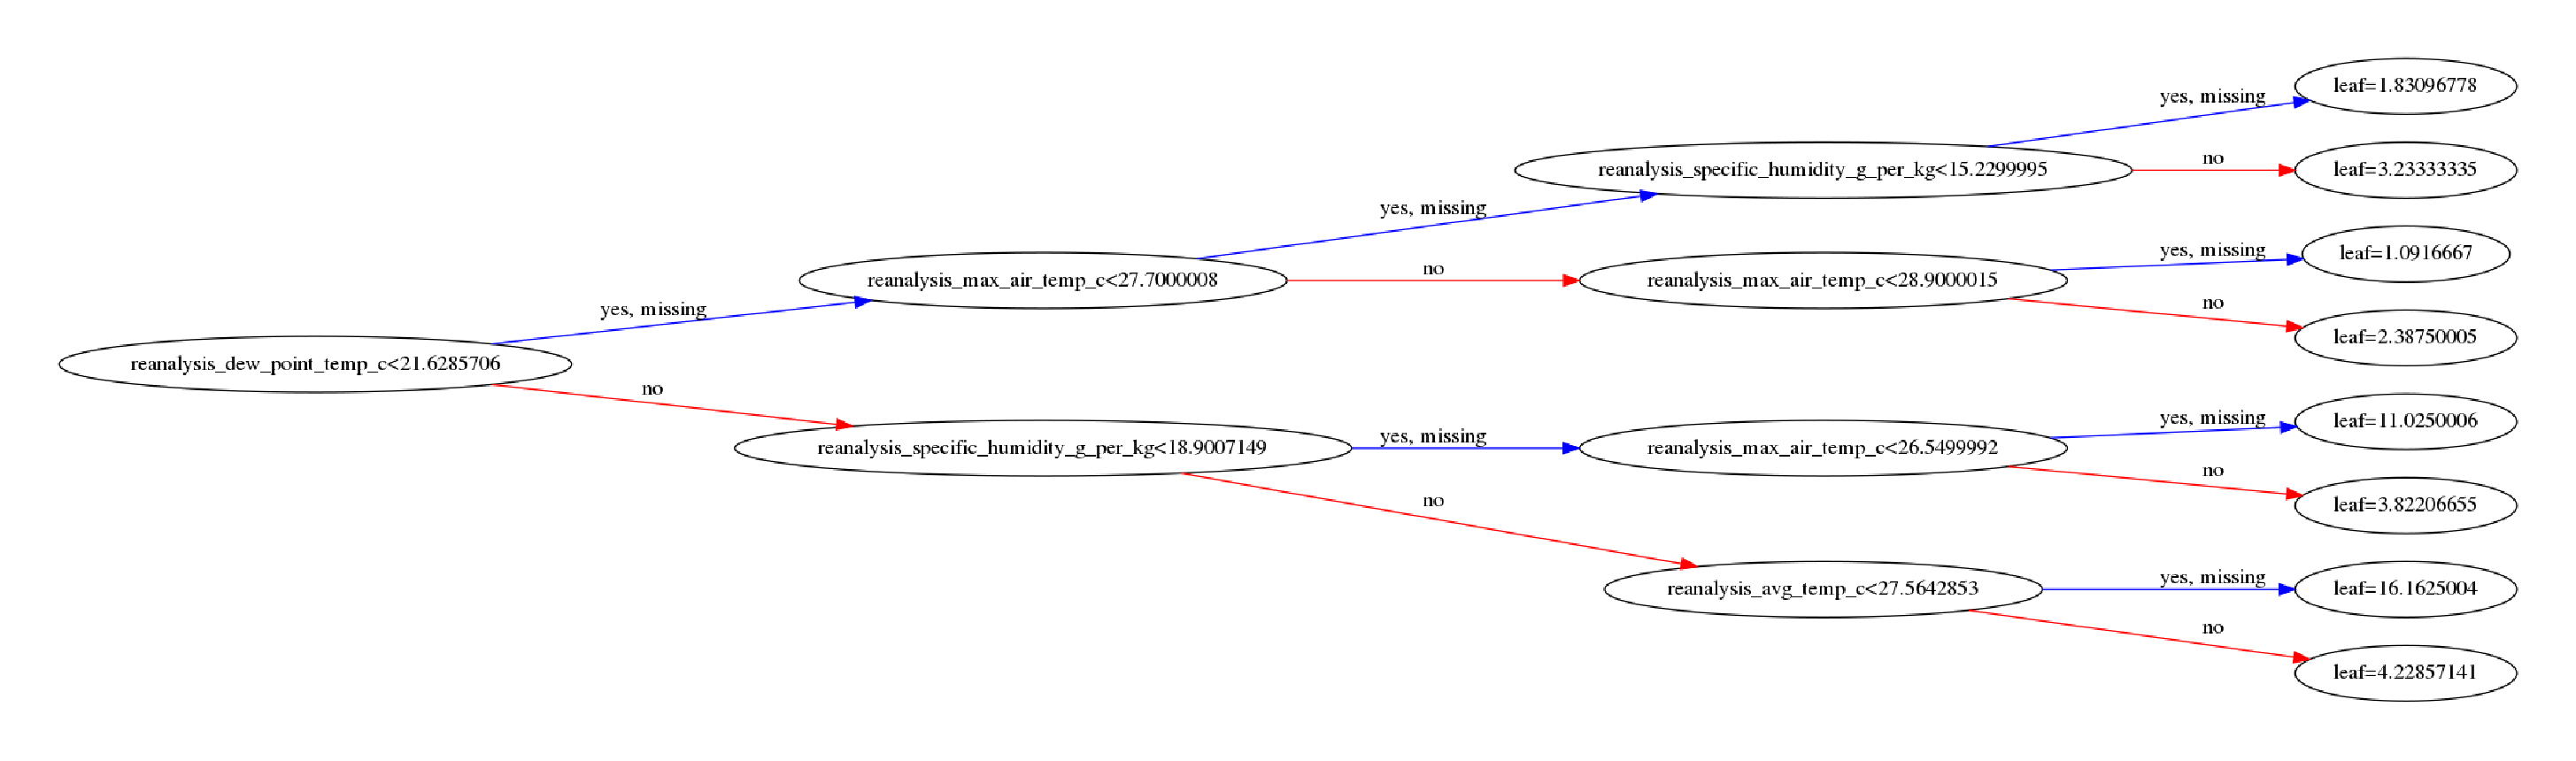

In [12]:
# plotting one of the decision tree
mpl.rcParams['figure.dpi'] = 600
#%config InlineBackend.figure_format = 'svg'
plot_tree(boost_clf_sj, num_trees=0, rankdir='LR')

In [13]:
# Converting it to dataframes for easy access
df_sj_Y_pred = pd.DataFrame(Y_test_sj)
df_sj_Y_pred['predictions'] = predictions_sj

df_iq_Y_pred = pd.DataFrame(Y_test_iq)
df_iq_Y_pred['predictions'] = predictions_iq

In [14]:
mse_sj = mean_squared_error(Y_test_sj.total_cases, predictions_sj)
mae_sj = mean_absolute_error(Y_test_sj.total_cases, predictions_sj)
print("For SJ: mse={:,.2f}  mae={:,.2f} Count={}".format(mse_sj, mae_sj, Y_test_sj.shape[0]))

mse_iq = mean_squared_error(Y_test_iq.total_cases, predictions_iq)
mae_iq = mean_absolute_error(Y_test_iq.total_cases, predictions_iq)
print("For iq: mse={:,.2f}  mae={:,.2f} Count={}".format(mse_iq, mae_iq, Y_test_iq.shape[0]))

For SJ: mse=3,290.16  mae=28.04 Count=281
For iq: mse=157.84  mae=6.85 Count=156


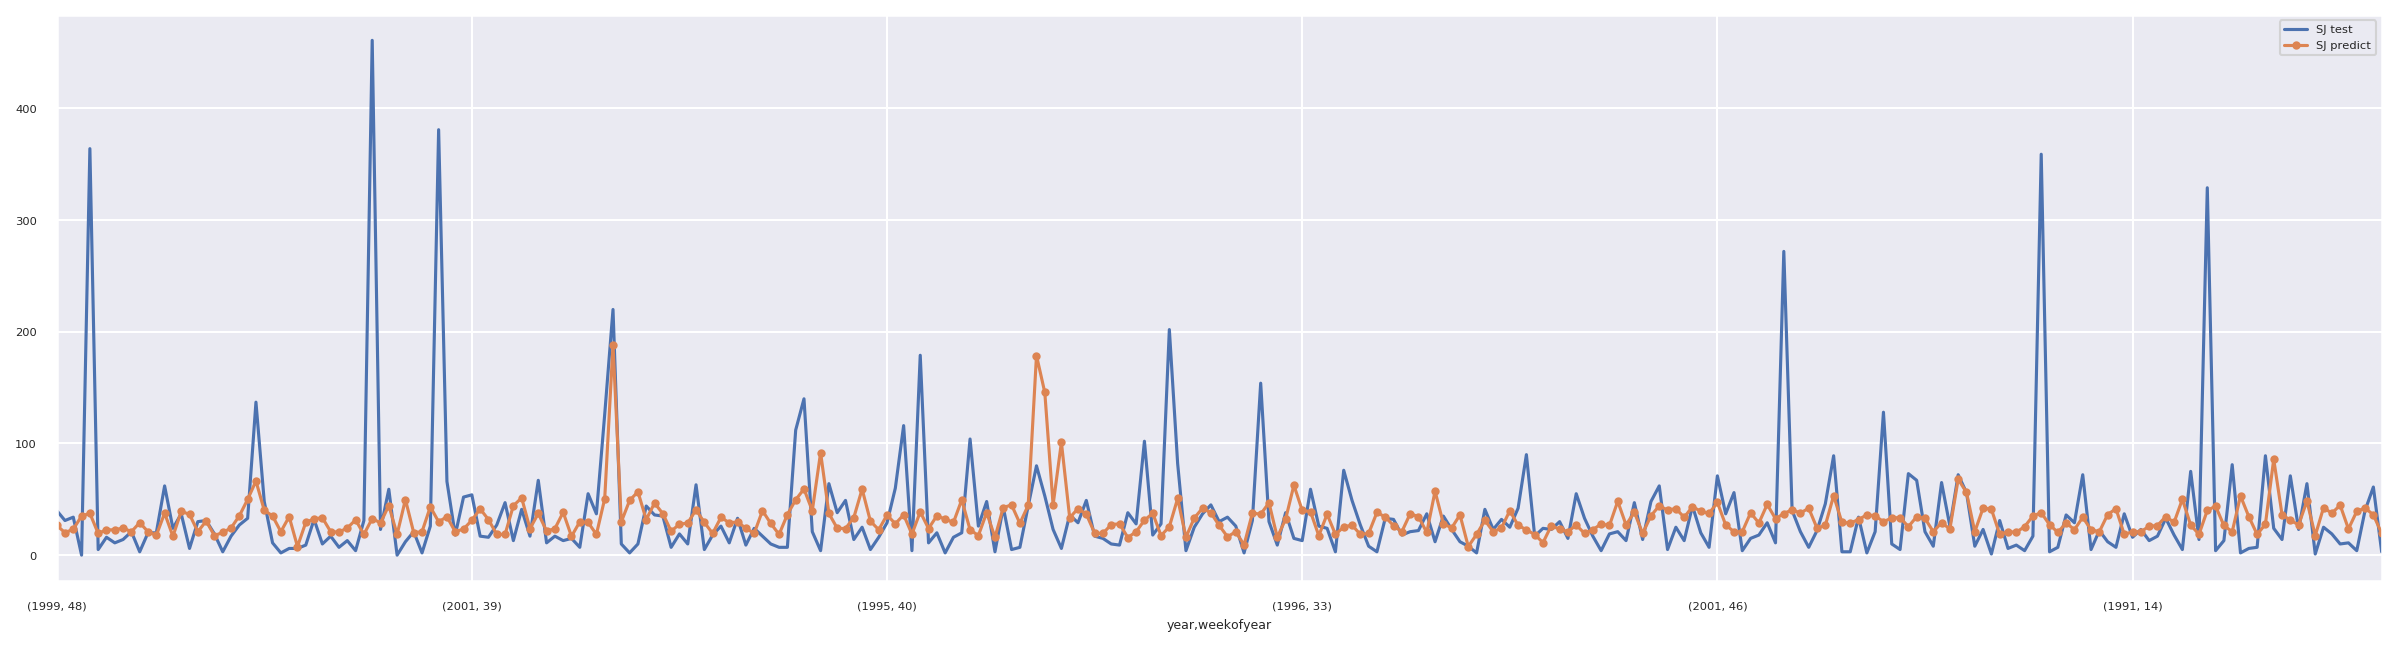

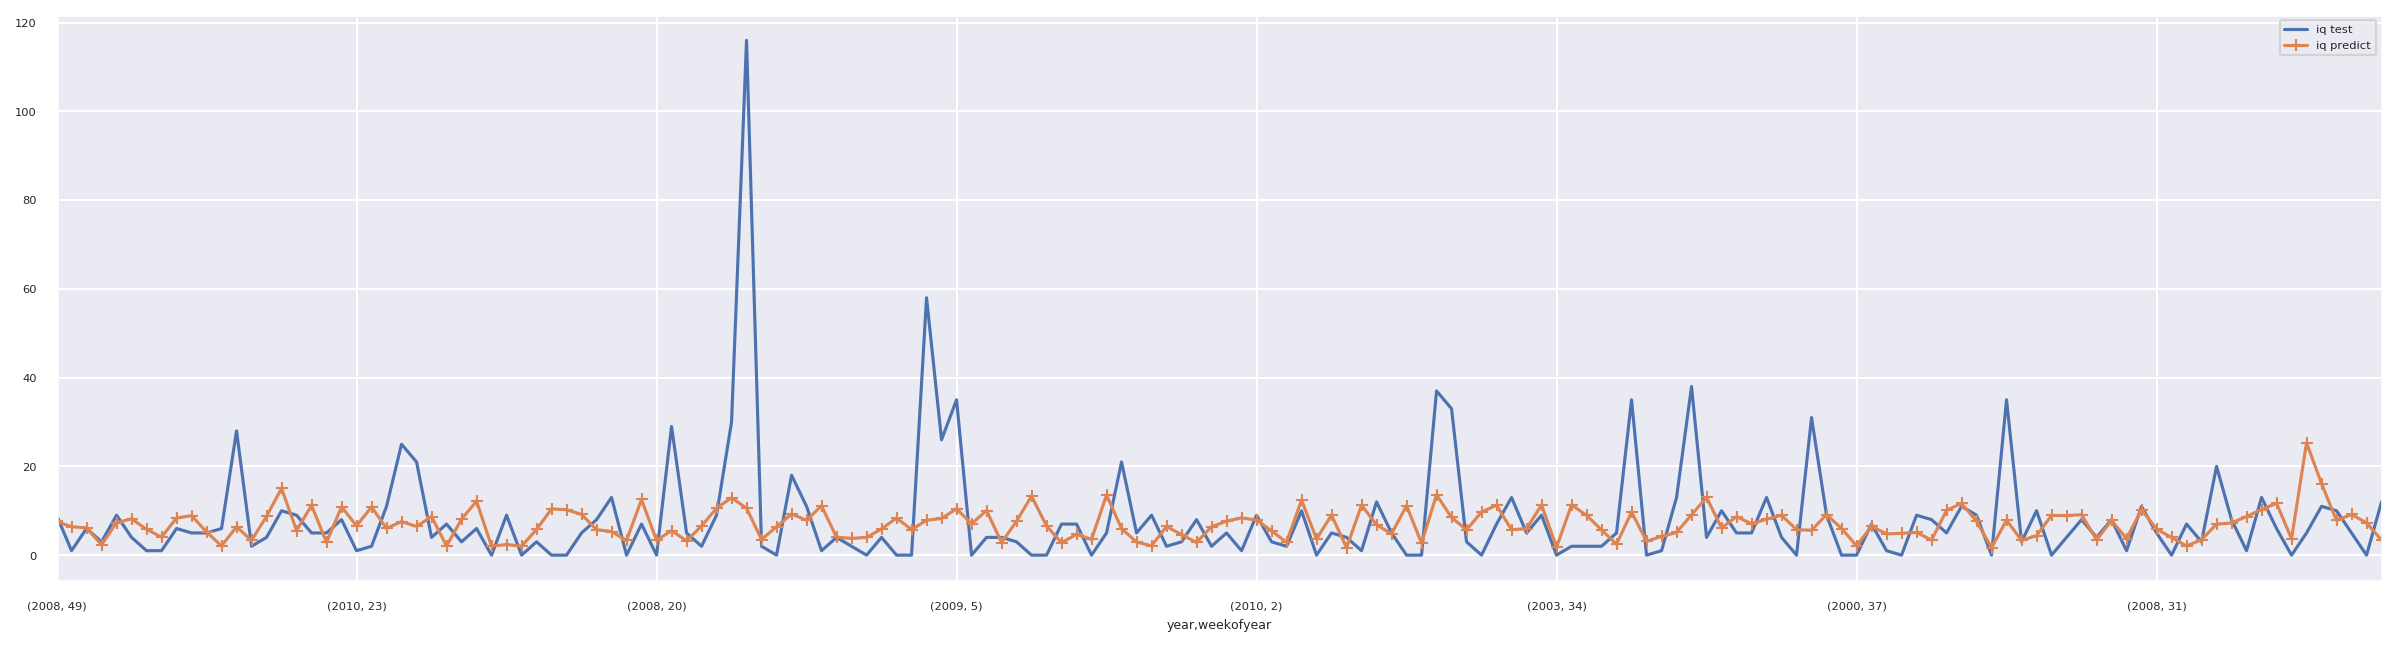

In [15]:
#For SJ: mse=1,479.78  mae=24.54 Count=281
#For iq: mse=147.05  mae=6.71 Count=156
#df.plot(style=['+-','o-','.--','s:'])

mpl.rcParams['figure.dpi'] = 150
plt.figure(figsize = (20, 5))
(df_sj_Y_pred
     .total_cases
     .plot(label='SJ test'))
(df_sj_Y_pred
     .predictions
     .plot(label='SJ predict', style='.-'))
plt.legend()

plt.figure(figsize = (20, 5))
(df_iq_Y_pred
     .total_cases
     .plot(label='iq test'))
(df_iq_Y_pred
     .predictions
     .plot(label='iq predict', style='-+'))
plt.legend()
plt.show()

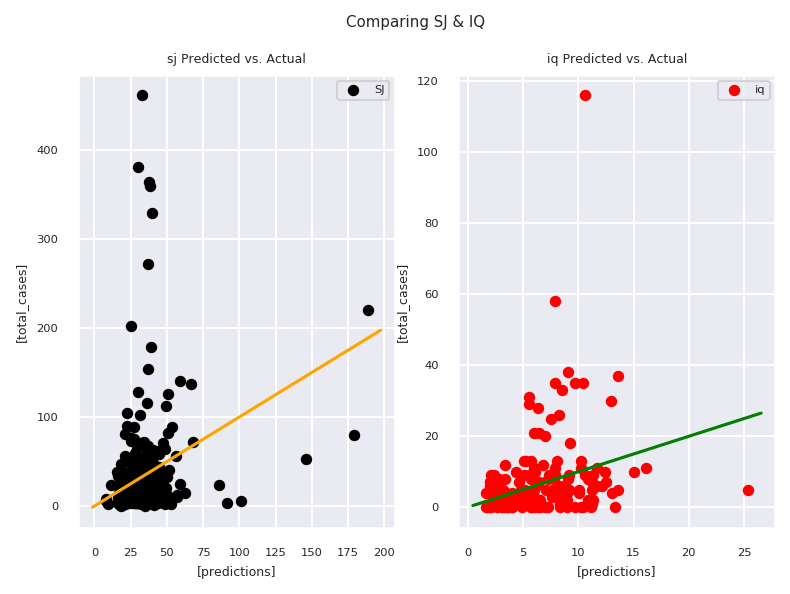

In [16]:
#plt.figure(figsize = (100, 10))
fig, axes = plt.subplots(1,2)
df_sj_Y_pred.plot(x=['predictions'], y=['total_cases'], 
                  kind="scatter", color='black', label='SJ', ax=axes[0])
df_iq_Y_pred.plot(x=['predictions'], y=['total_cases'], 
                  kind="scatter", color='red', label='iq', ax=axes[1])
x0 = np.linspace(*axes[0].get_xlim())
x1 = np.linspace(*axes[1].get_xlim())
axes[0].plot(x0, x0, c='orange')
axes[1].plot(x1, x1, c='green')
axes[0].set(title="sj Predicted vs. Actual")
axes[1].set(title="iq Predicted vs. Actual") #, aspect='equal')
fig.suptitle("Comparing SJ & IQ")
plt.legend()
plt.savefig("/tmp/QQ.png")
plt.show()


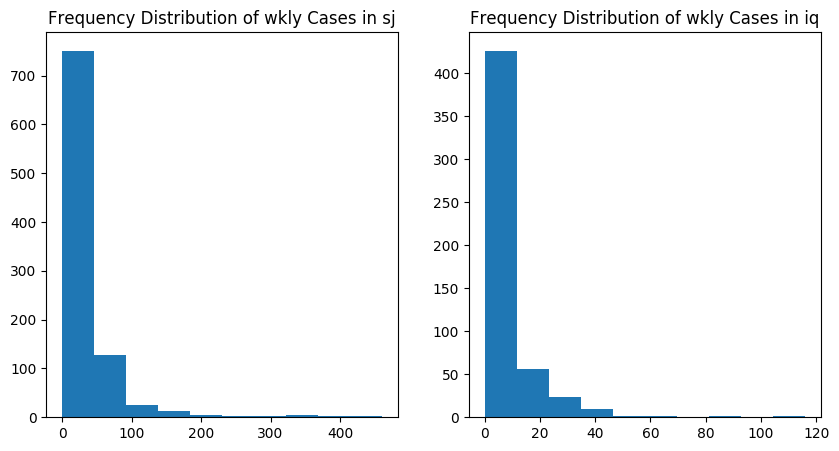

In [17]:
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train_y.loc['sj'].total_cases)
plt.title('Frequency Distribution of wkly Cases in sj') 

plt.subplot(1, 2, 2)
plt.hist(df_train_y.loc['iq'].total_cases)
plt.title('Frequency Distribution of wkly Cases in iq') 

plt.show()

### Definitely NOT normal distribution: Poisson($\lambda$=1), Exponential or a Negative Binomial Distribution? 

In [18]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dicky Fuller test for Unit Root

In [19]:
adf_sj_test = adfuller(df_train_y.loc['sj'].total_cases)
adf_iq_test = adfuller(df_train_y.loc['iq'].total_cases)
    

print('ADF Stat: {:,.4f}'.format(adf_sj_test[0]))
print('p-value:  {:,.4f}'.format(adf_sj_test[1]))
print('Critical Values:')
for key, value in adf_sj_test[4].items():
    print('   {:3s}:   {:,.3f}'.format(key, value))

print('\n')
print('ADF Stat: {:,.4f}'.format(adf_iq_test[0]))
print('p-value:  {:,.4f}'.format(adf_iq_test[1]))
print('Critical Values:')
for key, value in adf_iq_test[4].items():
    print('   {:3s}:   {:,.3f}'.format(key, value))

ADF Stat: -6.6501
p-value:  0.0000
Critical Values:
   1% :   -3.437
   5% :   -2.865
   10%:   -2.568


ADF Stat: -6.0854
p-value:  0.0000
Critical Values:
   1% :   -3.443
   5% :   -2.867
   10%:   -2.570


p-value of the Augmented Dickey Fuller Test < 5%, 
Reject the null hypothesis
this is stationary series, i.e. our series contains a unit root.